In [2]:
import ffmpeg
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skvideo
skvideo.setFFmpegPath(r'C:\Users\ion\anaconda3\envs\tf-gpu\Lib\site-packages\ffmpeg-4.3.1-2020-11-02-full_build\bin')
import skvideo.io


from os import listdir
from os.path import splitext
from os.path import join

%matplotlib inline

## Explanation of different datasets
The Aff-Wild2 dataset is used for training, validation and testing. While the AFEW 7.0 dataset is only used for testing. 

#### AFEW 7.0
In this dataset each video shows only one facial expression displayed, therefore each video is placed in a folder, where the folder name represents the facial expression class. The test dataset videos classes are not given, therefore only the train+validation set will be combined to use for final testing results of the model.

The Training and validation sets are combined in one folder called Val+train_AFEW, which sits inside the AFEW 7.0 Dataset folder.

In [3]:
from load_filenames import AF7_dir_videos, AF7_dir_labels, AF7_labeled_videos_FN

## Functions

# AFEW 7.0 Dataset Size

In [4]:
# Size of each set
AF7_all_videos = [j for i in AF7_dir_labels for j in AF7_labeled_videos_FN.get(i)]

print(f"The training+validation set contains: {len(AF7_all_videos)} videos")

The training+validation set contains: 1156 videos


# Sequence length of each video ###

Only FFmpeg is able to extract all frames, probably has to do with encoding of the videos. SKvideo/OpenCV all return incorrent amount of frames (2/3 frames sometimes)

https://github.com/kkroening/ffmpeg-python/issues/63


In [4]:
# Create dictionary of sequence length
AF7_seqlength = {}

# Save the shape information of the array for each file in the previously made dictionary
for label in AF7_labeled_videos_FN.keys():
    videos = AF7_labeled_videos_FN.get(label)
    for video in videos:

        probe = ffmpeg.probe(join(AF7_dir_videos, join(label, video)))
        video_info = next(x for x in probe["streams"] if x["codec_type"] == "video")
        width = int(video_info["width"])
        height = int(video_info["height"])

        out, _ = (
            ffmpeg.input(join(AF7_dir_videos, join(label, video)))
            .output("pipe:", format="rawvideo", pix_fmt="rgb24")
            .run(capture_stdout=True)
        )
        frames = np.frombuffer(out, np.uint8).reshape([-1, height, width, 3])

        AF7_seqlength[video] = frames.shape

In [5]:
# Save json file with all video's names and shapes = (n_frames, width, height, colour channels)
with open("data/AF7_video_shapes.json", "w") as fp:
    json.dump(AF7_seqlength, fp)

In [5]:
# Load AFEW video_shapes.json
with open("data/AF7_video_shapes.json", "r") as fp:
    AF7_video_shapes = json.load(fp)

## Some Summary statistics about video frames

In [7]:
AF7_all_sequenceslength = [items[0] for items in list(AF7_video_shapes.values())]
print(f"The mean length of all video sequences is: {np.mean(AF7_all_sequenceslength)} frames")
print(
    f"The median length of all video sequences is: {np.median(AF7_all_sequenceslength)} frames"
)
print(f"The SD of length of all video sequences is: {np.std(AF7_all_sequenceslength)} frames")
print(f"Total amount of frames/images in the dataset is: {sum(AF7_all_sequenceslength)} frames")

The mean length of all video sequences is: 63.146447140381284 frames
The median length of all video sequences is: 59.0 frames
The SD of length of all video sequences is: 25.40473506324535 frames
Total amount of frames/images in the dataset is: 72871 frames


### Violinplot of sequence length per resolution

All the videos have the same resolution: 720x576

The AFEW dataset only has the videoresolution:{'720x576'}


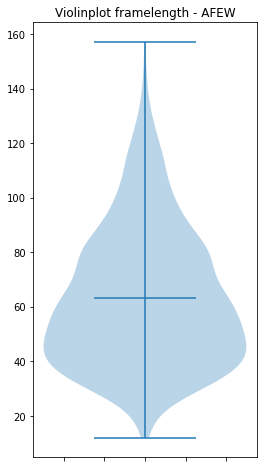

In [42]:
names = [
    (str(items[2]) + "x" + str(items[1])) for items in list(AF7_video_shapes.values())
]
fig, axes = plt.subplots(figsize=(4, 8))
axes.set_title("Violinplot framelength - AFEW")
axes.violinplot(AF7_all_sequenceslength, showmeans=True)
axes.set_xticklabels([]);

print(f'The AFEW dataset only has the videoresolution:{set(names)}')

## Framerate of each video 

In [50]:
for label in AF7_labeled_videos_FN.keys():
    print(label)

Angry
Disgust
Fear
Happy
Neutral
Sad
Surprise


In [69]:
# Grab the framerate for each video in the AFEW dataset.
# Then convert it to avg framerate value in decimals.
AF7_framerates = {}
for label in AF7_labeled_videos_FN.keys():
    videos = AF7_labeled_videos_FN.get(label)
    for video in videos:
        metadata = skvideo.io.ffprobe(join(AF7_dir_videos, join(label,video)))
        num, denom = (metadata.get("video").get("@avg_frame_rate")).split("/")
        AF7_framerates[video] = int(num) / int(denom)

In [70]:
len(AF7_framerates)

1154

In [85]:
# Put all framerates in a list
AF7_all_framerates = []
for videos in AF7_labeled_videos_FN.values():
    for video in videos:
        AF7_all_framerates.append(AF7_framerates.get(video))

# Count the occurence of each framerate to get the distribution
AF7_framerates_dist = {
    framerate: AF7_all_framerates.count(framerate) for framerate in sorted(set(AF7_all_framerates))
}

In [87]:
AF7_framerates_dist

{25.0: 1156}

In [91]:
AF7_classdist = {label:len(AF7_labeled_videos_FN.get(label)) for label in AF7_labeled_videos_FN.keys()}

In [92]:
AF7_classdist

{'Angry': 197,
 'Disgust': 114,
 'Fear': 127,
 'Happy': 213,
 'Neutral': 207,
 'Sad': 178,
 'Surprise': 120}